In [3]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [2]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import pandas as pd
import numpy as np
from scipy.stats import randint
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D, Bidirectional,GRU,Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.utils import to_categorical
lemmatizer = WordNetLemmatizer()


df = pd.read_csv('stock_data.csv')
df['Text'] = df['Text'].astype(str)
df['Date'] = pd.to_datetime(df['Date'])
df['Sentiment'] = df['Sentiment'].astype(np.int64)
print(df.info())

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

to_remove = ['up', 'down','low','high','below','less','fall']
new_stopwords = set(stopwords.words('english')).difference(to_remove)
stemmer = SnowballStemmer(language='english')
def text_data_cleaning(sentence):
    sent = preprocess_text(sentence)
    doc = nltk.word_tokenize(sent)
    lemma =[stemmer.stem(word) for word in doc]
    return append_message(lemma)
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    sentence = sen.lower()
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub('Stocks|market', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) 
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(new_stopwords) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

def append_message(text):
  str = " "
  return (str.join(text))

df['Tok_text'] = df['Text'].apply(text_data_cleaning)
df['Tok_text'] = df['Tok_text'].astype(str)

df = df.drop_duplicates(subset='Tok_text',keep='first')
df2 = df.iloc[:,2:]

X = df2['Tok_text']
y= df2['Sentiment']

df_train, df_test = train_test_split(df2, test_size=0.3, random_state=42,
                                     stratify=df2['Sentiment'])
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42,
                                     stratify=df_test['Sentiment'])

vocab = set()
for x in X:
    vocab.add(x)
tokenizer = Tokenizer(num_words=len(vocab))
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_length = max(len(sequence) for sequence in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.3, random_state=42,stratify=y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52804 entries, 0 to 52803
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Text       52804 non-null  object        
 1   Date       52804 non-null  datetime64[ns]
 2   Sentiment  52804 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.2+ MB
None


In [7]:
import pickle
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
pickle.dump(sequences, open("sequences.pkl", "wb"))
pickle.dump(max_length, open("max_length.pkl", "wb"))

Epoch 1/5
13/13 [==============================] - 22s 1s/step - loss: 1.0230 - sparse_categorical_accuracy: 0.4983 - val_loss: 0.8945 - val_sparse_categorical_accuracy: 0.5208
Epoch 2/5
13/13 [==============================] - 18s 1s/step - loss: 0.7185 - sparse_categorical_accuracy: 0.6891 - val_loss: 0.5554 - val_sparse_categorical_accuracy: 0.8009
Epoch 3/5
13/13 [==============================] - 18s 1s/step - loss: 0.4279 - sparse_categorical_accuracy: 0.8455 - val_loss: 0.3749 - val_sparse_categorical_accuracy: 0.8573
Epoch 4/5
13/13 [==============================] - 16s 1s/step - loss: 0.2921 - sparse_categorical_accuracy: 0.8968 - val_loss: 0.3432 - val_sparse_categorical_accuracy: 0.8710
Epoch 5/5
491/491 [==============================] - 2s 4ms/step - loss: 0.3431 - sparse_categorical_accuracy: 0.8744
Test loss: 0.3431006371974945
491/491 [==============================] - 2s 4ms/step
Score for label 0: 79.62%
Score for label 1: 86.94%
Score for label 2: 79.54%


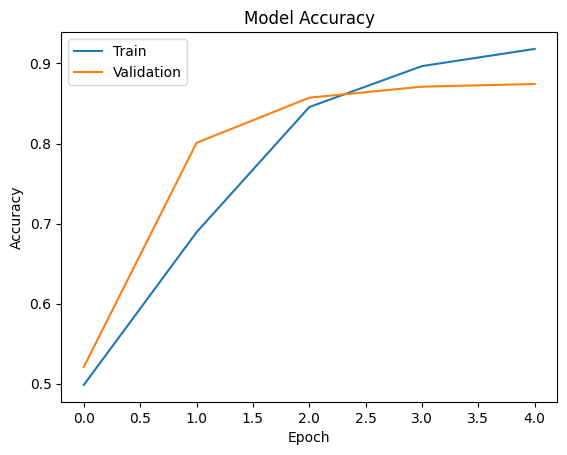

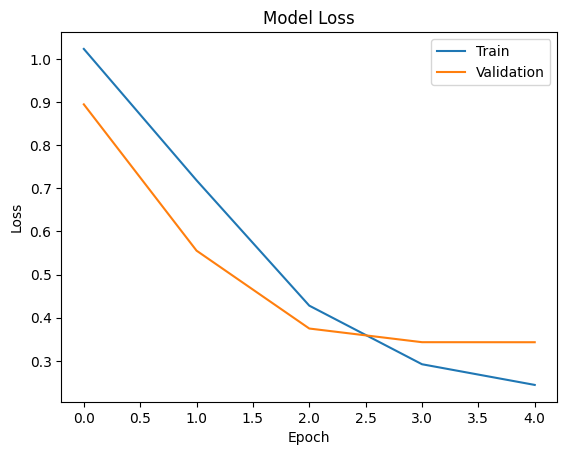

In [2]:
# Define model architecture
from sklearn.metrics import accuracy_score, classification_report
model = Sequential()
model.add(Embedding(len(vocab), 150, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
optimizer = Adam(
    learning_rate=2e-03, # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['sparse_categorical_accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=3000)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
y_pred = model.predict(X_test)
label_scores = {}
for i, label in enumerate(set(y)):
    idx = np.where(y_test == i)[0]
    label_scores[label] = np.mean(y_pred[idx, i])

# print the label specific score
for label in label_scores:
    print('Score for label {}: {:.2f}%'.format(label, label_scores[label] * 100))

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [14]:
model.save('Lstm.h5')

In [17]:

# Define model architecture
model = Sequential()
model.add(Embedding(len(vocab), 128, input_length=max_length))
model.add(SpatialDropout1D(0.5))
model.add(Bidirectional(GRU(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(len(set(y)), activation='softmax'))
optimizer = Adam(
    learning_rate=1e-03, # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['sparse_categorical_accuracy'])

# Train model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=3000)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
y_pred = model.predict(X_test)
label_scores = {}
for i, label in enumerate(set(y)):
    idx = np.where(y_test == i)[0]
    label_scores[label] = np.mean(y_pred[idx, i])

# print the label specific score
for label in label_scores:
    print('Score for label {}: {:.2f}%'.format(label, label_scores[label] * 100))


Epoch 1/8
13/13 [==============================] - 26s 2s/step - loss: 1.0368 - sparse_categorical_accuracy: 0.4920 - val_loss: 0.9820 - val_sparse_categorical_accuracy: 0.5085
Epoch 2/8
13/13 [==============================] - 24s 2s/step - loss: 0.8973 - sparse_categorical_accuracy: 0.5764 - val_loss: 0.7684 - val_sparse_categorical_accuracy: 0.6617
Epoch 3/8
13/13 [==============================] - 24s 2s/step - loss: 0.6827 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.5741 - val_sparse_categorical_accuracy: 0.7883
Epoch 4/8
13/13 [==============================] - 24s 2s/step - loss: 0.4986 - sparse_categorical_accuracy: 0.8106 - val_loss: 0.4388 - val_sparse_categorical_accuracy: 0.8341
Epoch 5/8
13/13 [==============================] - 25s 2s/step - loss: 0.3857 - sparse_categorical_accuracy: 0.8570 - val_loss: 0.3823 - val_sparse_categorical_accuracy: 0.8551
Epoch 6/8
13/13 [==============================] - 25s 2s/step - loss: 0.3234 - sparse_categorical_accuracy: 0.8809

In [12]:
# Save the model
model.save('biGRU.h5')

In [3]:

# Define model architecture
model = Sequential()
model.add(Embedding(len(vocab), 128, input_length=max_length))
model.add(SpatialDropout1D(0.5))
model.add(Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(set(y)), activation='softmax'))
optimizer = Adam(
    learning_rate=2e-03, # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['sparse_categorical_accuracy'])
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Train model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=3000)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
y_pred = model.predict(X_test)
label_scores = {}
for i, label in enumerate(set(y)):
    idx = np.where(y_test == i)[0]
    label_scores[label] = np.mean(y_pred[idx, i])

# print the label specific score
for label in label_scores:
    print('Score for label {}: {:.2f}%'.format(label, label_scores[label] * 100))


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/8
13/13 [==============================] - 43s 3s/step - loss: 1.0381 - sparse_categorical_accuracy: 0.4916 - val_loss: 0.9559 - val_sparse_categorical_accuracy: 0.5123
Epoch 2/8
11/13 [========================>.....] - ETA: 4s - loss: 0.8481 - sparse_categorical_accuracy: 0.6131

KeyboardInterrupt: 

In [83]:
model.save('biGRU1.h5')

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout

ticker_symbol = 'ADANIENT.NS'

start_date = '2022-12-14'
end_date = '2023-05-14'

stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

close_data = stock_data['Close'].values

seq_length = 60

train_size = int(len(close_data) * 0.8)
train_data = close_data[:train_size]
test_data = close_data[train_size - seq_length:]

max_value = np.max(close_data)
min_value = np.min(close_data)
normalized_train_data = (train_data - min_value) / (max_value - min_value)
normalized_test_data = (test_data - min_value) / (max_value - min_value)

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(normalized_train_data, seq_length)
X_test, y_test = create_sequences(normalized_test_data, seq_length)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=50, batch_size=32)

predictions = model.predict(X_test)

predictions = predictions * (max_value - min_value) + min_value

mse = np.mean((predictions - test_data) ** 2)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: ", rmse)



[*********************100%***********************]  1 of 1 completed
Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.0408
Epoch 2/50
1/1 [==============================] - 0s 72ms/step - loss: 0.0271
Epoch 3/50
1/1 [==============================] - 0s 64ms/step - loss: 0.0163
Epoch 4/50
1/1 [==============================] - 0s 64ms/step - loss: 0.0054
Epoch 5/50
1/1 [==============================] - 0s 64ms/step - loss: 0.0020
Epoch 6/50
1/1 [==============================] - 0s 72ms/step - loss: 0.0055
Epoch 7/50
1/1 [==============================] - 0s 57ms/step - loss: 0.0064
Epoch 8/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0052
Epoch 9/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0019
Epoch 10/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0012
Epoch 11/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0015
Epoch 12/50
1/1 [==============================] - 0s 66ms/step - loss: 0

In [37]:
y_test_new= y_test * (max_value - min_value) + min_value
date_new=stock_data.index.values[(len(data)-249):len(stock_data)]
plt.plot(date_new, predictions, label='Prediction price')
plt.plot(date_new, y_test_new, label='Original price')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')

plt.show()

NameError: name 'data' is not defined

[*********************100%***********************]  1 of 1 completed
Epoch 1/20
27/27 [==============================] - 2s 4ms/step - loss: 0.0488
Epoch 2/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 3/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 4/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 5/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 6/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 7/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 8/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 9/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 11/20
27/27 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 12/20
27/27 [==============================] - 0s 4ms/

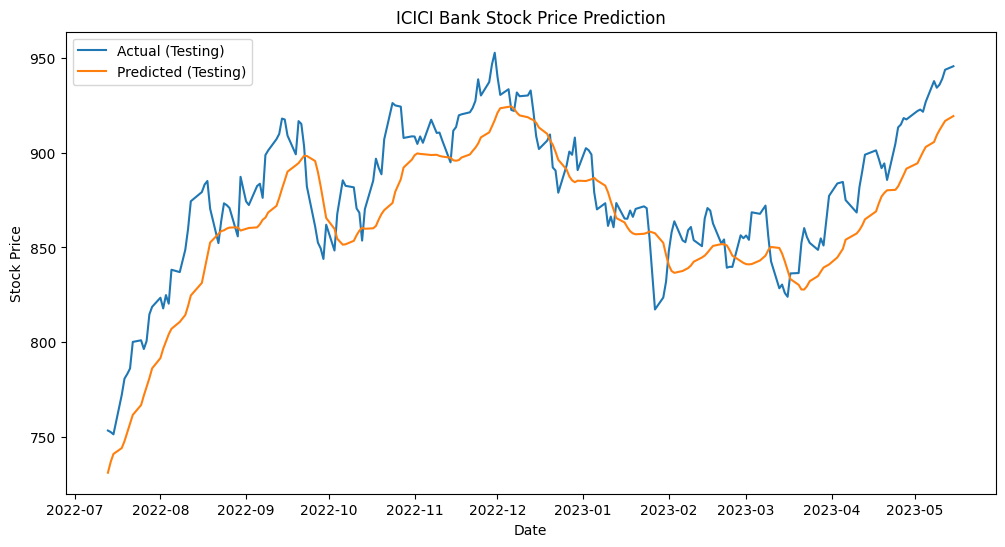

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Fetching historical stock data for ICICI Bank
data = yf.download('ICICIBANK.NS', start='2019-01-01', end='2023-05-16')

# Preprocessing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Splitting the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Preparing the data for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Length of input sequences
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Building the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Making predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse scaling for plotting the predictions
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Plotting the predictions
plt.figure(figsize=(12, 6))
#plt.plot(data.index[seq_length:seq_length+len(train_predictions)], y_train, label='Actual (Training)')
plt.plot(data.index[seq_length+len(train_predictions)+seq_length:], y_test, label='Actual (Testing)')
#plt.plot(data.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Predicted (Training)')
plt.plot(data.index[seq_length+len(train_predictions)+seq_length:], test_predictions, label='Predicted (Testing)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('ICICI Bank Stock Price Prediction')
plt.legend()
plt.show()


Epoch 1/50
60/60 [==============================] - 5s 32ms/step - loss: 0.0141
Epoch 2/50
60/60 [==============================] - 2s 31ms/step - loss: 0.0062
Epoch 3/50
60/60 [==============================] - 2s 31ms/step - loss: 0.0052
Epoch 4/50
60/60 [==============================] - 2s 30ms/step - loss: 0.0047
Epoch 5/50
60/60 [==============================] - 2s 29ms/step - loss: 0.0048
Epoch 6/50
60/60 [==============================] - 2s 27ms/step - loss: 0.0042
Epoch 7/50
60/60 [==============================] - 2s 27ms/step - loss: 0.0042
Epoch 8/50
60/60 [==============================] - 2s 29ms/step - loss: 0.0037
Epoch 9/50
60/60 [==============================] - 2s 31ms/step - loss: 0.0037
Epoch 10/50
60/60 [==============================] - 2s 28ms/step - loss: 0.0038
Epoch 11/50
60/60 [==============================] - 2s 28ms/step - loss: 0.0033
Epoch 12/50
60/60 [==============================] - 2s 28ms/step - loss: 0.0038
Epoch 13/50
60/60 [==================

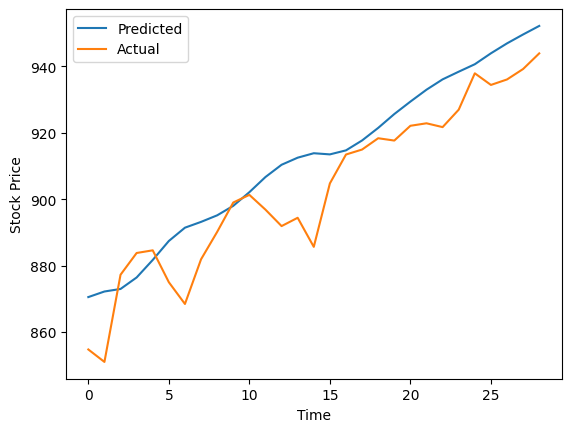

In [13]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Fetch historical data using yfinance
stock_symbol = "ICICIBANK.NS"
start_date = "2015-01-01"
end_date = "2023-05-16"
data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

# Split the data into train and test sets
train_data = scaled_data[data.index <= "2023-01-01"]
test_data = scaled_data[data.index > "2023-01-01"]

# Create the training data sequences
sequence_length = 60  # Adjust the sequence length as needed
train_sequences = []
for i in range(sequence_length, len(train_data)):
    train_sequences.append(train_data[i - sequence_length:i, 0])

train_sequences = np.array(train_sequences)
X_train = train_sequences[:, :-1]
y_train = train_sequences[:, -1]

# Reshape the data for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.5))
model.add(LSTM(units=50))
model.add(Dropout(0.5))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

# Create the test data sequences
test_sequences = []
for i in range(sequence_length, len(test_data)):
    test_sequences.append(test_data[i - sequence_length:i, 0])

test_sequences = np.array(test_sequences)
X_test = test_sequences[:, :-1]
y_test = test_sequences[:, -1]

# Reshape the data for LSTM input (samples, time steps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the predicted vs actual stock prices
plt.plot(predictions, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


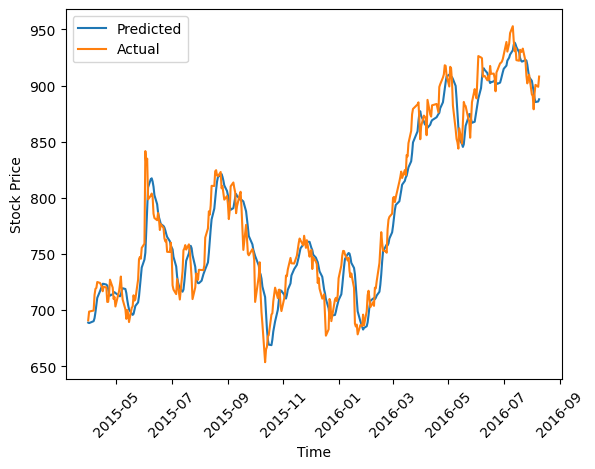

In [12]:
# Plot the predicted vs actual stock prices
plt.plot(data.index[sequence_length: len(test_data)],predictions, label="Predicted")
plt.plot(data.index[sequence_length: len(test_data)],y_test, label="Actual")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Epoch 1/50
63/63 [==============================] - 5s 25ms/step - loss: 0.0296
Epoch 2/50
63/63 [==============================] - 2s 25ms/step - loss: 0.0080
Epoch 3/50
63/63 [==============================] - 2s 25ms/step - loss: 0.0066
Epoch 4/50
63/63 [==============================] - 2s 25ms/step - loss: 0.0065
Epoch 5/50
63/63 [==============================] - 2s 27ms/step - loss: 0.0055
Epoch 6/50
63/63 [==============================] - 2s 31ms/step - loss: 0.0054
Epoch 7/50
63/63 [==============================] - 2s 34ms/step - loss: 0.0050
Epoch 8/50
63/63 [==============================] - 2s 34ms/step - loss: 0.0044
Epoch 9/50
63/63 [==============================] - 2s 34ms/step - loss: 0.0050
Epoch 10/50
63/63 [==============================] - 2s 34ms/step - loss: 0.0048
Epoch 11/50
63/63 [==============================] - 2s 34ms/step - loss: 0.0042
Epoch 12/50
63/63 [==============================] - 2s 34ms/step - loss: 0.0046
Epoch 13/50
63/63 [==================

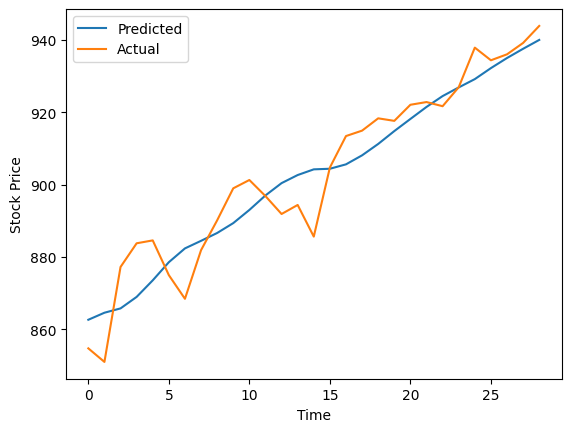

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Fetch historical data using yfinance
stock_symbol = "ICICIBANK.NS"
start_date = "2015-01-01"
end_date = "2023-05-16"
data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

# Split the data into train and test sets
train_data = scaled_data[data.index <= "2023-05-16"]
test_data = scaled_data[data.index > "2023-01-01"]

# Create the training data sequences
sequence_length = 60  # Adjust the sequence length as needed
train_sequences = []
for i in range(sequence_length, len(train_data)):
    train_sequences.append(train_data[i - sequence_length:i, 0])

train_sequences = np.array(train_sequences)
X_train = train_sequences[:, :-1]
y_train = train_sequences[:, -1]

# Reshape the data for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.5))
model.add(LSTM(units=50))
model.add(Dropout(0.5))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

# Create the test data sequences
test_sequences = []
for i in range(sequence_length, len(test_data)):
    test_sequences.append(test_data[i - sequence_length:i, 0])

test_sequences = np.array(test_sequences)
X_test = test_sequences[:, :-1]
y_test = test_sequences[:, -1]

# Reshape the data for LSTM input (samples, time steps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the predicted vs actual stock prices
plt.plot(predictions, label="Predicted")
plt.plot(y_test, label="Actual")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
